In [22]:
# Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from keras.models import Sequential
from tqdm.notebook import tqdm
from tensorflow.keras.utils  import to_categorical
from keras.preprocessing.image import load_img, img_to_array
import warnings 
from keras.layers import Dense, Dropout, Convolution2D, Flatten, MaxPooling2D


In [2]:
warnings.filterwarnings("ignore") # Ignore warnings

In [3]:

TRAIN_DIR = 'Facial-Expression-dataset/train'
TEST_DIR = 'Facial-Expression-dataset/test'


In [4]:
# load the dataset

def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  
        if os.path.isdir(label_path):  # check it's a folder
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)
            print(label, "completed")
    return image_paths, labels  

In [5]:
# convert to dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
# convert labels to categorical
train['label'] = pd.Categorical(train['label'])
train.head()

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,Facial-Expression-dataset/train\sad\Training_5...,sad
1,Facial-Expression-dataset/train\happy\Training...,happy
2,Facial-Expression-dataset/train\fear\Training_...,fear
3,Facial-Expression-dataset/train\neutral\Traini...,neutral
4,Facial-Expression-dataset/train\happy\Training...,happy


In [6]:
# convert to dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,Facial-Expression-dataset/test\angry\PrivateTe...,angry
1,Facial-Expression-dataset/test\angry\PrivateTe...,angry
2,Facial-Expression-dataset/test\angry\PrivateTe...,angry
3,Facial-Expression-dataset/test\angry\PrivateTe...,angry
4,Facial-Expression-dataset/test\angry\PrivateTe...,angry


<Axes: xlabel='label', ylabel='count'>

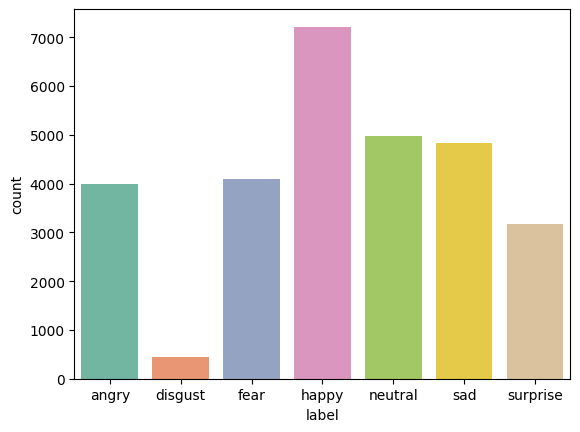

In [7]:
sns.countplot(x='label', data=train, palette='Set2')

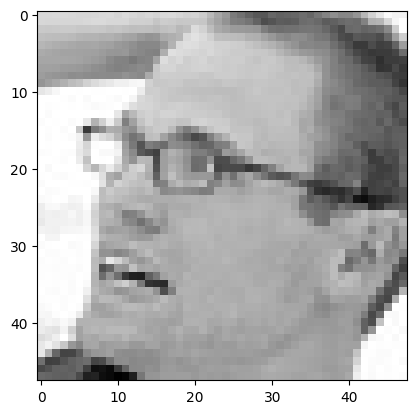

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(train['image'][0])
# Display the image in grayscale
plt.imshow(img, cmap='gray')
plt.show()


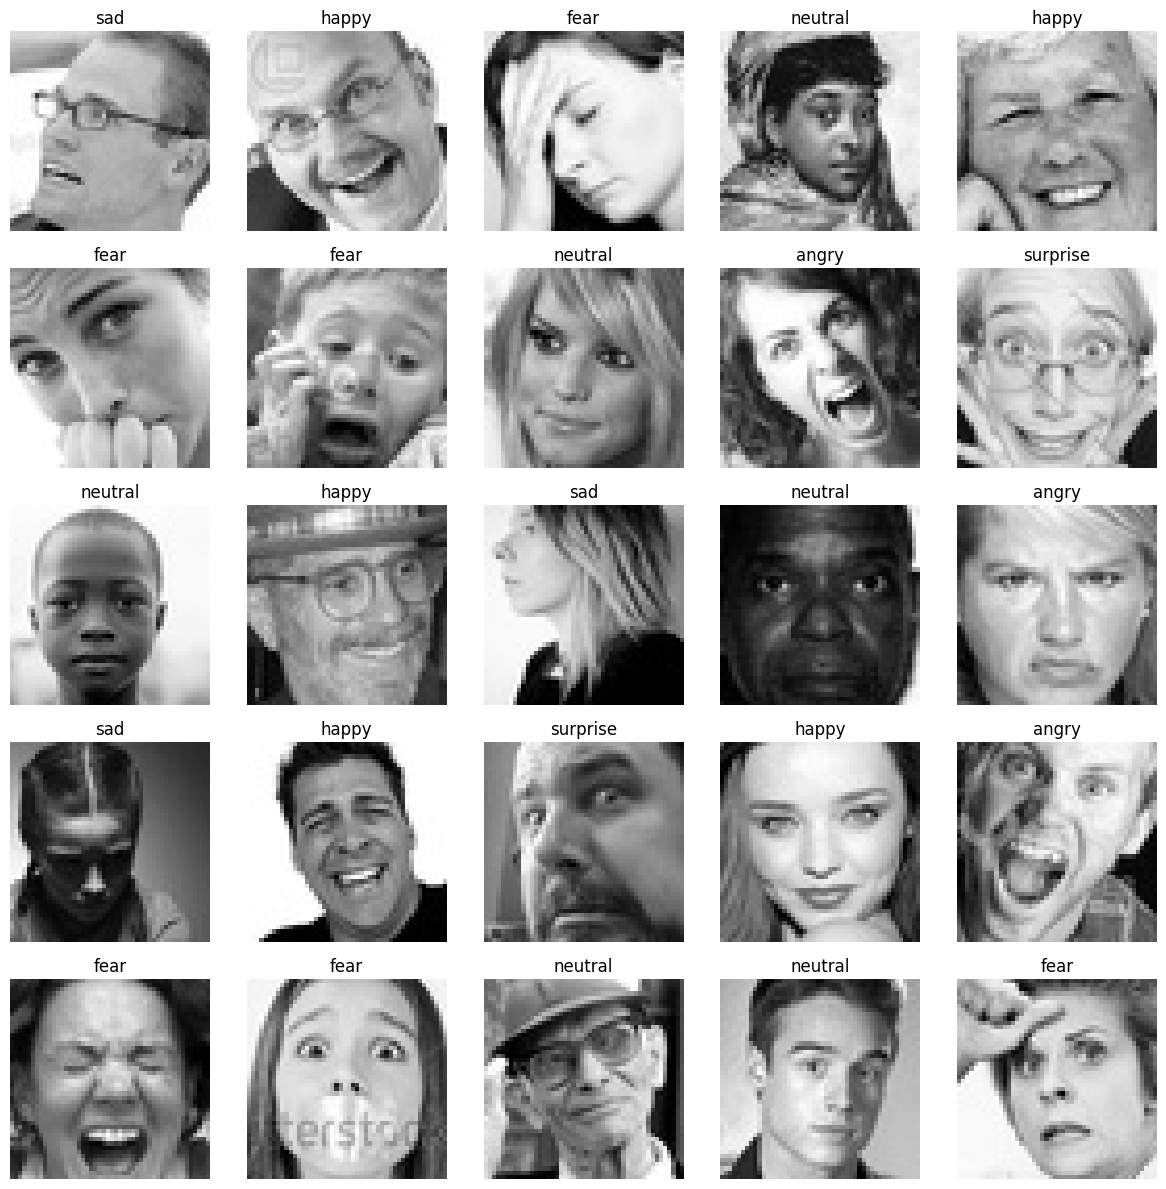

In [9]:
# display grid of images
plt.figure(figsize=(12, 12))
files = train.iloc[:25]
for index, row in files.iterrows():
    plt.subplot(5, 5, index % 25 + 1)
    
    # Load image in grayscale and resize
    img = load_img(row['image'], color_mode='grayscale', target_size=(48, 48))
    img = img_to_array(img)
    
    # Display image
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.title(row['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# extract features from images
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
        img = img_to_array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Reshape for CNN input
    return features

In [11]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [12]:
# normalize the image
x_train = train_features / 255.0
x_test = test_features / 255.0

In [13]:
# convert labels to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
# convert labels to categorical
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [15]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [16]:
# Config
input_shape = (48, 48, 1)
output_classes = 7

In [17]:
# model creation
model = Sequential() 
model.add(Convolution2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) # Convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2))) # Pooling layer
model.add(Dropout(0.25))  # Dropout layer to prevent overfitting

model.add(Convolution2D(256, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Convolution2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Convolution2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.4))  
model.add(Dense(output_classes, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_classes, activation='softmax'))  # Output layer with softmax activation

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [30]:
# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)
# evaluate the model

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 482ms/step - accuracy: 0.5691 - loss: 1.1313 - val_accuracy: 0.5694 - val_loss: 1.1825
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 227s 506ms/step - accuracy: 0.5722 - loss: 1.1230 - val_accuracy: 0.5733 - val_loss: 1.1806
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 224s 499ms/step - accuracy: 0.5724 - loss: 1.1281 - val_accuracy: 0.5670 - val_loss: 1.1867
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 221s 492ms/step - accuracy: 0.5766 - loss: 1.1193 - val_accuracy: 0.5697 - val_loss: 1.1847
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 482ms/step - accuracy: 0.5784 - loss: 1.1053 - val_accuracy: 0.5719 - val_loss: 1.1823
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 220s 490ms/step - accuracy: 0.5873 - loss: 1.0977 - val_accuracy: 0.5705 - val_loss: 1.1801
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 220s 491ms/step - accuracy: 0.5807 - loss: 1.0927 - val_accuracy: 0.5715 - val_loss: 1.1792
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 219s 489ms/step - accuracy: 0.5927 -

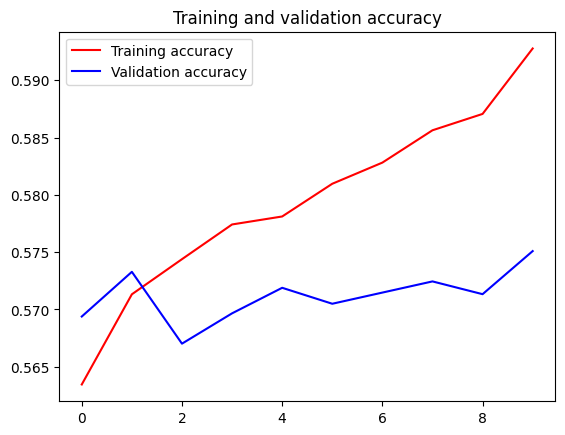

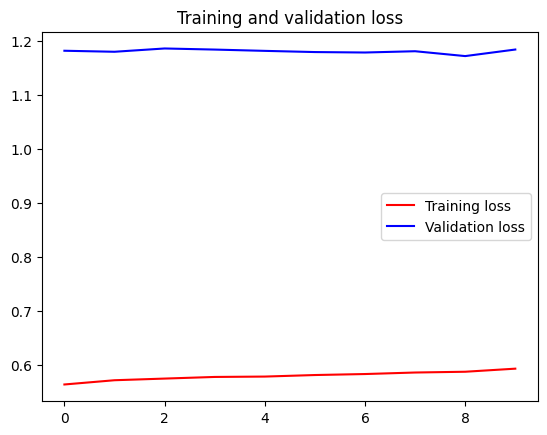

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

original label: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
predicted label: ['sad']


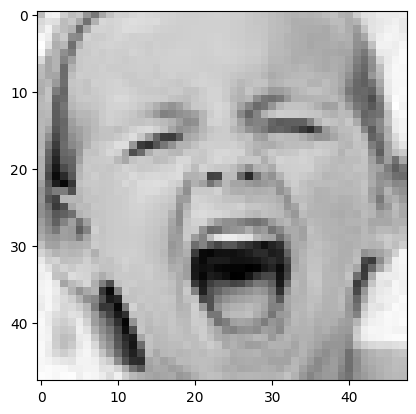

In [37]:
# Test the model
image_index = random.randint(0, len(test)-1)
print('original label:', test['label'][image_index])
predicted_label = model.predict(np.expand_dims(x_test[image_index], axis=0))
predicted_label = np.argmax(predicted_label, axis=1)
print('predicted label:', le.inverse_transform(predicted_label))
# Display the image
img = load_img(test['image'][image_index], color_mode='grayscale', target_size=(48, 48))
img = img_to_array(img)
plt.imshow(img.reshape(48, 48), cmap='gray')
plt.show()